In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

import sys
import os
sys.path.append('../python/')

import experiments as ex

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')
bigfont = 18
medfont = 14
smallfont = 12
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_palette("muted")

In [4]:
verbose = True
directory = '../data/'
example_z_index = 65


# Training Data

In [5]:
def plot_training(observer_name):
    filetag = observer_name

    if observer_name == 'carla-uav':
        scale = ex.CARLA_UAV_SCALE # multiplier to convert into meters
    elif observer_name == 'carla-car':
        scale = ex.CARLA_CAR_SCALE # multiplier to convert into meters

    with open('{}training_interconnection_{}.pkl'.format(directory,filetag), 'rb') as input:
        interconnection = pickle.load(input)
    params = np.load('{}training_{}.npz'.format(directory,filetag))
    C = params['C']
    controller_C = interconnection.controller.C
    yref = params['yref']
    ys_label = interconnection.zs_c

    if observer_name == 'carla-uav':
        plt.figure(figsize=[2,2])
        ax = plt.subplot(1,1,1)
        plt.grid()


        ax.set_axisbelow(True)


        y_train = np.array(interconnection.xs) @ C.T
        x_train = np.array(interconnection.xs)
        plt.scatter(scale * x_train[:,2], scale * x_train[:,0], s=0.25, c='black', label='training data')
        plt.scatter(scale * x_train[example_z_index,2], scale * x_train[example_z_index,0], s=100, 
                    c='yellow', marker='*', edgecolor='black', label='example')
        plt.axis('equal')
        plt.xlabel('x position (m)'); plt.ylabel('y position (m)'); 
        plt.tight_layout()


    elif observer_name == 'carla-car':
        fig = plt.figure(figsize=[3,3])
        ax = fig.add_subplot(111, projection='3d')
        fig.subplots_adjust(top=1) #, bottom=0, left=-0.1, right=1)
        x_train = np.array(interconnection.xs)
        ax.scatter(scale*x_train[:,2], scale*x_train[:,0], np.rad2deg(np.arctan2(x_train[:,1],x_train[:,3])), '.',
                   color='black', s=1,alpha=0.1)

        ax.scatter(scale*x_train[example_z_index,2], scale*x_train[example_z_index,0],
                   np.rad2deg(np.arctan2(x_train[example_z_index,1],x_train[example_z_index,3]))+30,
                   s=100,  c='yellow', marker='*', edgecolor='black', label='example')

        plt.xlabel('x position (m)')
        plt.ylabel('y position (m)')
        ax.set_zlabel('angle (degrees)')
        
    plt.figure(figsize=[3,2])
    plt.imshow(interconnection.zs[example_z_index])
    plt.axis('off')
    
    return interconnection.zs
        

       

<IPython.core.display.Javascript object>


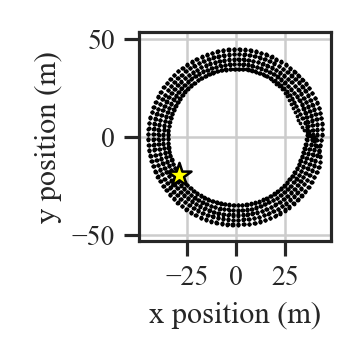

<IPython.core.display.Javascript object>


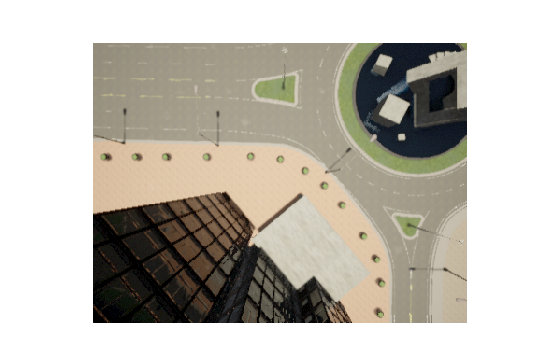

<IPython.core.display.Javascript object>


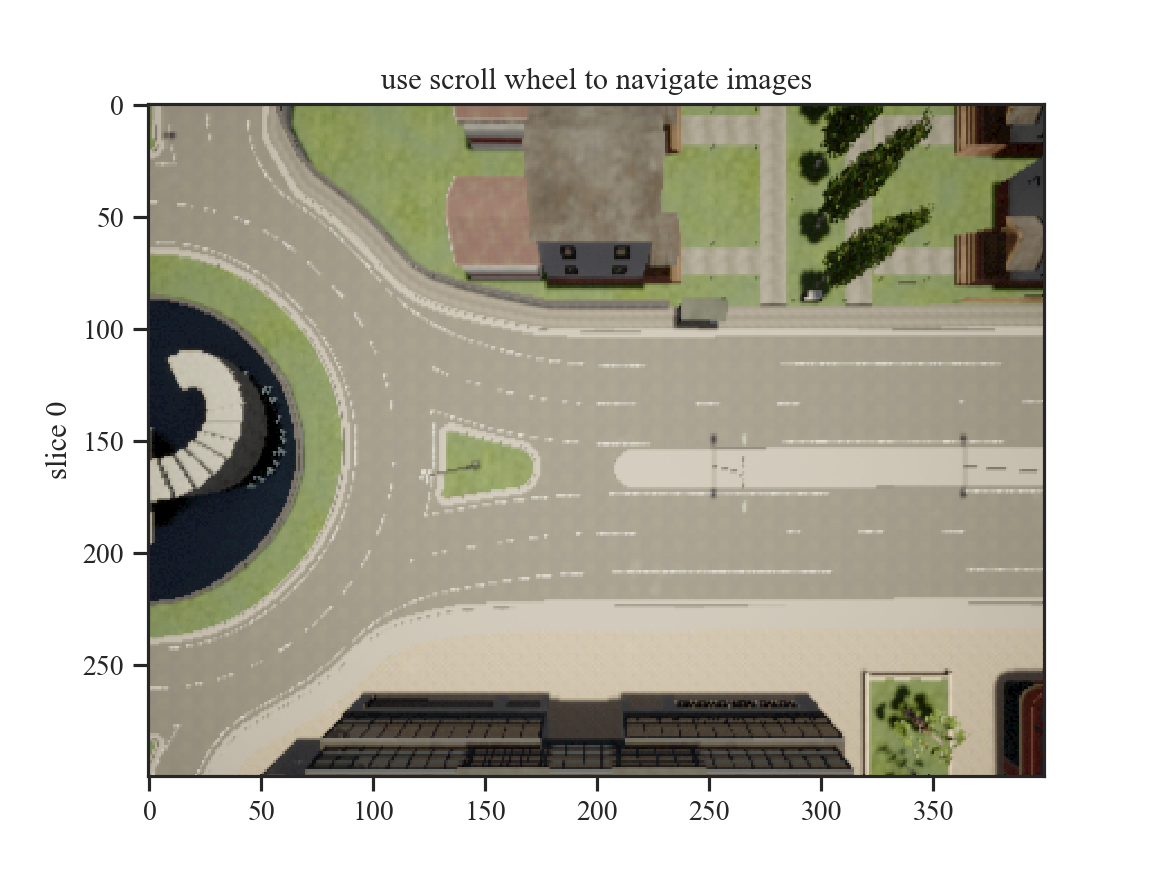

7

In [6]:
zs = plot_training('carla-uav')

fig, ax = plt.subplots(1, 1)
tracker = ex.IndexTracker(ax, zs)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


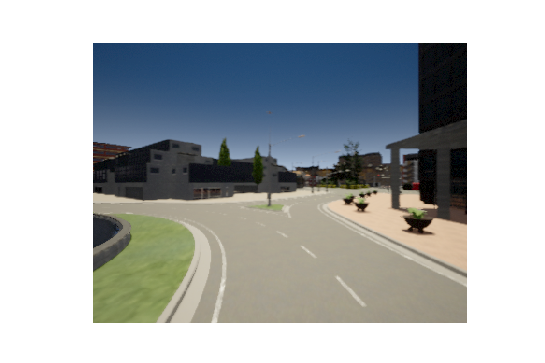

<IPython.core.display.Javascript object>

7

In [7]:
zs = plot_training('carla-car')

fig, ax = plt.subplots(1, 1)
tracker = ex.IndexTracker(ax, zs)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)

# Grid Evaluation

In [8]:
def plot_evaluation(observer_name):
    filetag = observer_name

    if observer_name == 'carla-uav':
        scale = ex.CARLA_UAV_SCALE # multiplier to convert into meters
    elif observer_name == 'carla-car':
        scale = ex.CARLA_CAR_SCALE # multiplier to convert into meters

    with open('{}training_interconnection_{}.pkl'.format(directory,filetag), 'rb') as input:
        interconnection = pickle.load(input)
    params = np.load('{}training_{}.npz'.format(directory,filetag))
    C = params['C']
    controller_C = interconnection.controller.C
    yref = params['yref']
    ys_label = interconnection.zs_c
    
    grid_params = np.load('{}grid_{}.npz'.format(directory,filetag))
    xs_grid = grid_params['xs_grid']
    zs_grid = grid_params['zs_grid']

    ys_true = np.array(xs_grid) @ C.T
    
    data_files = {}
    for filename in os.listdir(directory) :
        if 'estimates' in filename:
            info = filename.replace('.npz','').split('_')
            if len(info) == 4:
                first, file_predictor, file_param, file_observer_name = info
            else:
                first, file_predictor, file_observer_name = info
                file_param = None
            if file_observer_name == observer_name and first == 'estimates':
                if file_predictor not in data_files.keys():
                    data_files[file_predictor] = [file_param]
                else:
                    data_files[file_predictor] += [file_param]
    all_ys_est = {}
    all_errs_est = {}
    for key in data_files.keys():
        for param in data_files[key]:
            if param is not None:
                data = np.load('{}estimates_{}_{}_{}.npz'.format(directory, key, param, observer_name), allow_pickle=True)
                all_ys_est['{}_{}'.format(key,param)] = data['all_ys_est']
            else:
                data = np.load('{}estimates_{}_{}.npz'.format(directory, key, observer_name), allow_pickle=True)
                all_ys_est['{}'.format(key)] = data['all_ys_est']
            all_errs_est['{}_{}'.format(key,param)] = data['all_errs_est']

    for filename in os.listdir(directory) :
        if 'pose_est_sequential' in filename:
            file_observer_name = filename.replace('.npz','').split('_')[-1]
            if file_observer_name == observer_name:
                data = np.load('{}pose_est_sequential_{}.npz'.format(directory, observer_name), allow_pickle=True)
                all_ys_est['slam'] = data['pos_est'][:,:2] / scale
        elif 'pose_est' in filename:
            file_observer_name = filename.replace('.npz','').split('_')[-1]
            if file_observer_name == observer_name:
                data = np.load('{}pose_est_{}.npz'.format(directory, observer_name), allow_pickle=True)
                all_ys_est['slam-vo'] = data['pos_est'][:,:2] / scale

    err_min = scale * np.sqrt(1e-5) #  min([errs.min()] + [errs_b.min() for errs_b in errs_bs])
    err_max = scale * np.sqrt(1e2) # max([errs.max()] + [errs_b.max() for errs_b in errs_bs])

    xpos_list = xs_grid[:,0]
    ypos_list = xs_grid[:,2]

    def plot_errors(errs_sq, ngrid, title, ax=None):
        errs = scale * np.sqrt(errs_sq)

        if ax is None: fig, ax = plt.subplots(1, 1, figsize=[10/3,3])

        # scatterplot
        ax.set_title(title)
        im = ax.scatter(scale * ypos_list, scale * xpos_list, marker='s', c=errs,
                    norm=colors.LogNorm(vmin=err_min, vmax=err_max), 
                    cmap='hot')

        return im
    
    num_grid = 4
    grid_height = int(np.ceil(len(all_ys_est.keys())/num_grid))
    fig, axs = plt.subplots(grid_height, 
                            num_grid, figsize=[20/9 * num_grid, 2*grid_height])

    for ax, key in zip(axs.flatten(), all_ys_est.keys()):
        im = plot_errors((np.sum((ys_true-all_ys_est[key])**2, axis=1)), int(np.sqrt(xs_grid.shape[0])), 
                         title=key, ax=ax)
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    
    inner_region = [1.75+0.1, 2.25-0.1]
    outer_region = [1.25, 2.75]
    print(scale * np.array(inner_region),scale * np.array(outer_region))
    
    inner_mask = []
    outer_mask = []
    for y in ys_true:
        if y[0]**2 + y[1]**2 >= inner_region[0]**2 and y[0]**2 + y[1]**2 <= inner_region[1]**2:
            inner_mask.append(True)
        else:
            inner_mask.append(False)
        if y[0]**2 + y[1]**2 >= inner_region[1]**2 and y[0]**2 + y[1]**2 <= outer_region[1]**2:
            outer_mask.append(True)
        elif y[0]**2 + y[1]**2 <= inner_region[0]**2 and y[0]**2 + y[1]**2 >= outer_region[0]**2:
            outer_mask.append(True)
        else:
            outer_mask.append(False)
    inner_mask = np.array(inner_mask)
    outer_mask = np.array(outer_mask)

    def error_barchart(inner_errors, outer_errors, labels, figsize=[5,5]):

        plt.figure(figsize=figsize)
        ax = plt.subplot(1,1,1)
        width = 0.25
        ticks = np.arange(len(labels))
        plt.bar(ticks-width/2, inner_errors[:,0], width=width, label='inner errors', yerr=inner_errors[:,1:].T,
               color='firebrick')
        plt.bar(ticks+width/2, outer_errors[:,0], width=width, label='outer errors', yerr=outer_errors[:,1:].T,
               color='darkgoldenrod')
        plt.xticks(ticks, labels)
        plt.yscale("log")
        plt.ylim([scale * np.sqrt(1e-5),scale*1e3])
        plt.legend()
        plt.tight_layout()
        return ax

    
    if observer_name == 'carla-uav':
        best = ['kernel_25000.0', #'kernel-gaussian_105.52525252525251',
                'krr_0.11120000000000001', 'slam-vo', 'slam']
    elif observer_name == 'carla-car':
        best = ['kernel_13333.333333333334', 'slam-vo', 'slam']
        
        
    num_for_plot_grid = len(best)
    fig, axs = plt.subplots(int(np.ceil(len(best)/num_for_plot_grid)), num_for_plot_grid,
                           figsize=[9/4*len(best)*0.9,2])


    key_to_label = {'kernel': 'NW', 'kernel-gaussian': 'blur-NW', 'krr': 'KRR', 'slam-vo': 'VO', 
                   'slam': 'SLAM'}

    for ax, key in zip(axs.flatten(),best):
        im = plot_errors(np.sum((ys_true-all_ys_est[key])**2, axis=1), int(np.sqrt(xs_grid.shape[0])),
                    title=key_to_label[key.split('_')[0]], ax=ax)
    plt.tight_layout()

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)


    inner_errors = []; outer_errors = []; labels = []
    for key in best:
        errs = np.sqrt(np.sum((scale * (ys_true-all_ys_est[key]))**2, axis=1))
        inner_errors.append([np.quantile(errs[inner_mask], q) for q in [0.5, 0.0, 0.99]])
        outer_errors.append([np.quantile(errs[outer_mask], q) for q in [0.5, 0.0, 0.99]])
        labels.append(key.split('_')[0])

    inner_errors = np.array(inner_errors); outer_errors = np.array(outer_errors)


    ax = error_barchart(inner_errors, outer_errors, [key_to_label[label] for label in labels], figsize=[3,2])
    plt.grid()
    ax.set_axisbelow(True)

    

<IPython.core.display.Javascript object>


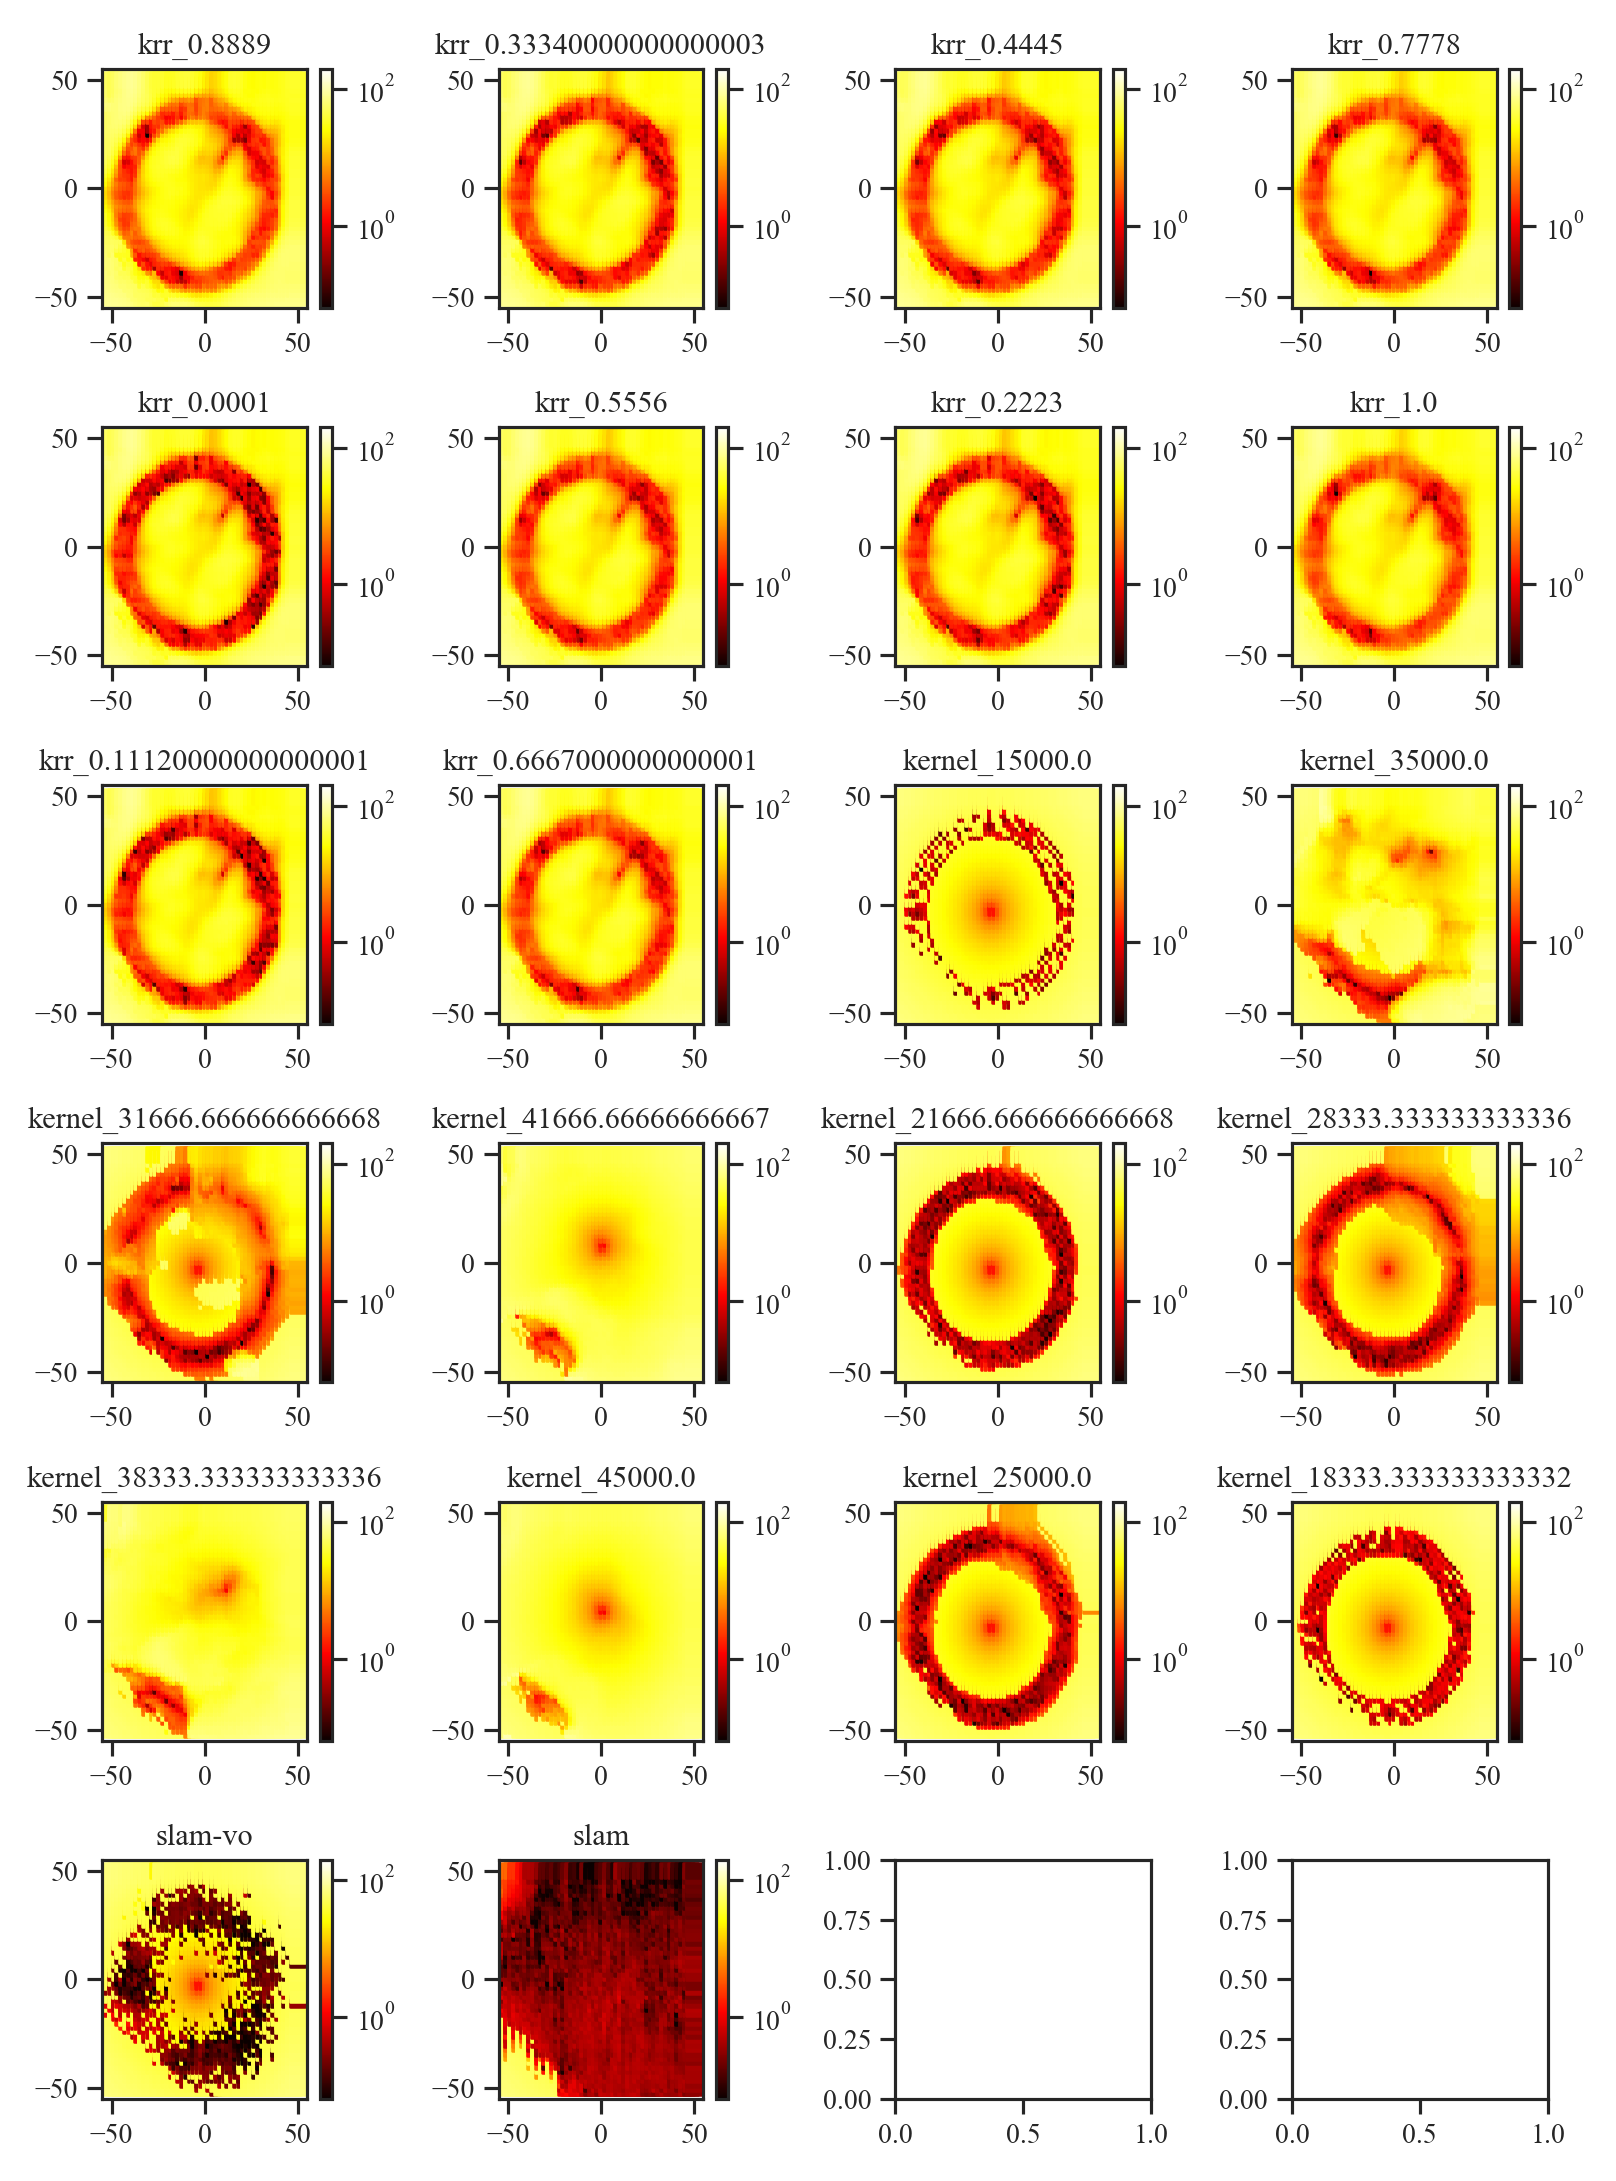

[37. 43.] [25. 55.]


<IPython.core.display.Javascript object>


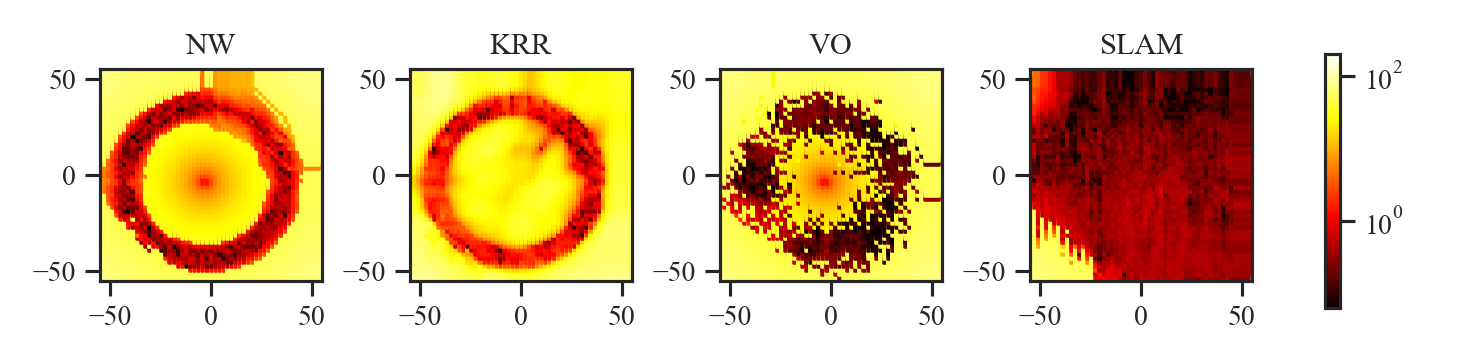

<IPython.core.display.Javascript object>


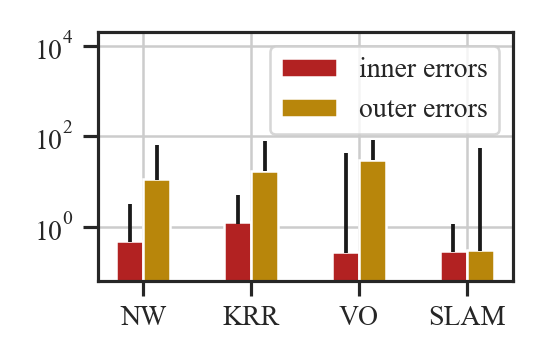

In [9]:
plot_evaluation('carla-uav')

<IPython.core.display.Javascript object>


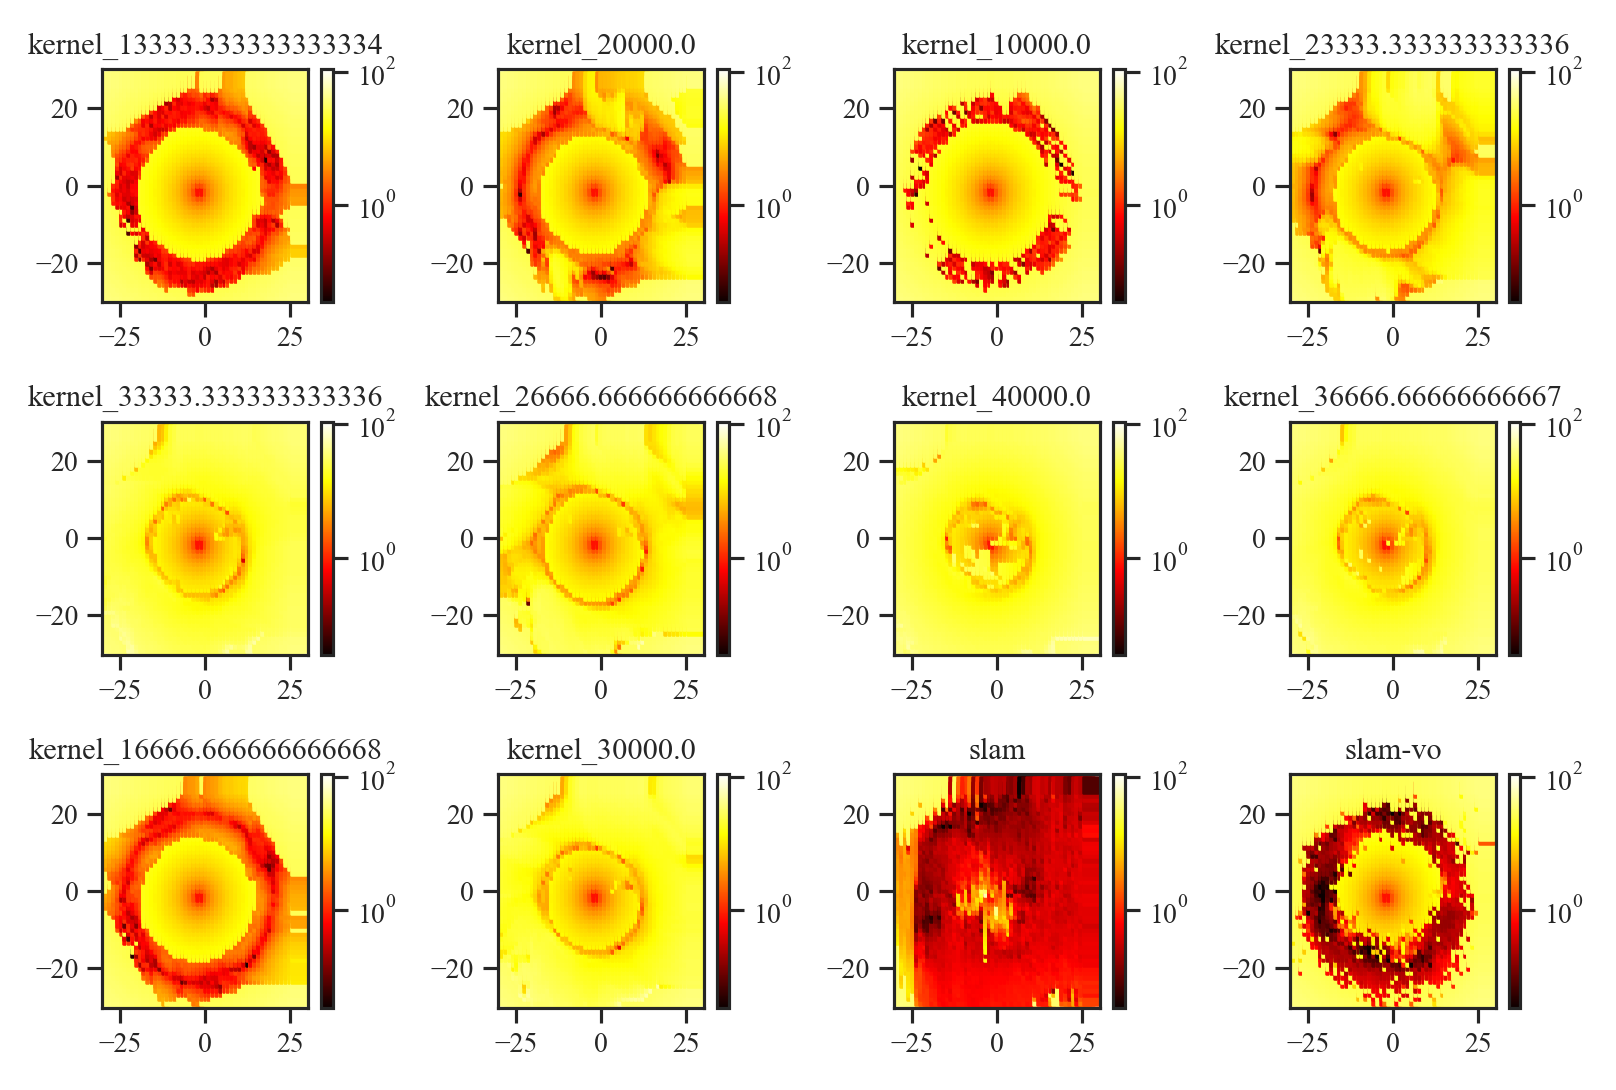

[20.35 23.65] [13.75 30.25]


<IPython.core.display.Javascript object>


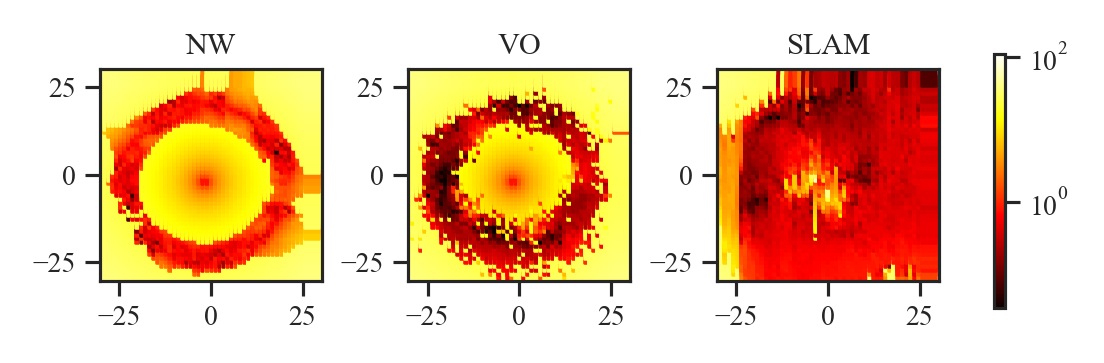

<IPython.core.display.Javascript object>


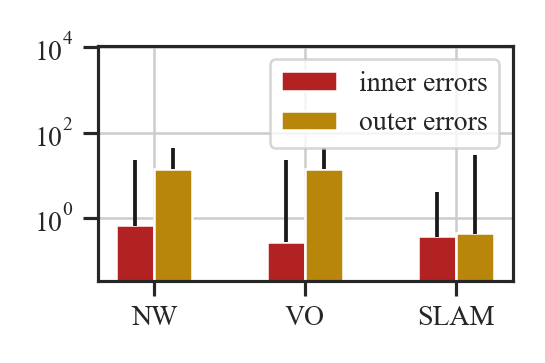

In [10]:
plot_evaluation('carla-car')

# Closed-Loop operation

<IPython.core.display.Javascript object>


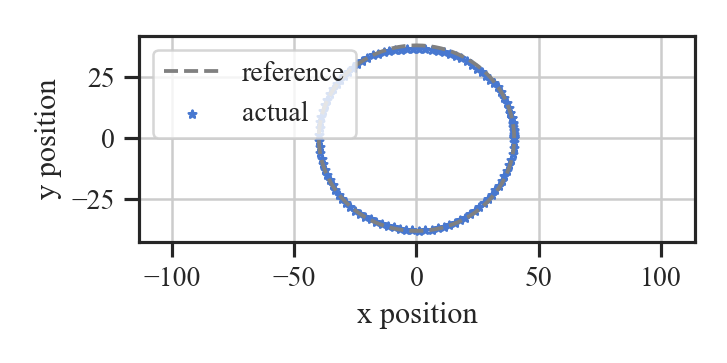

<IPython.core.display.Javascript object>


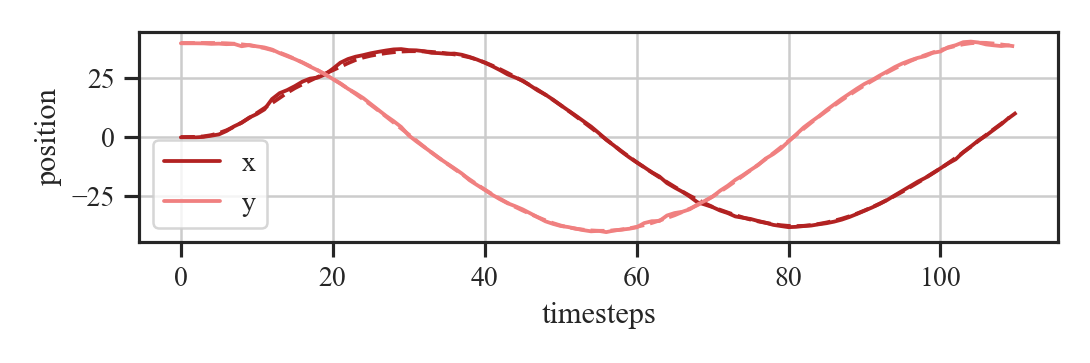

<IPython.core.display.Javascript object>


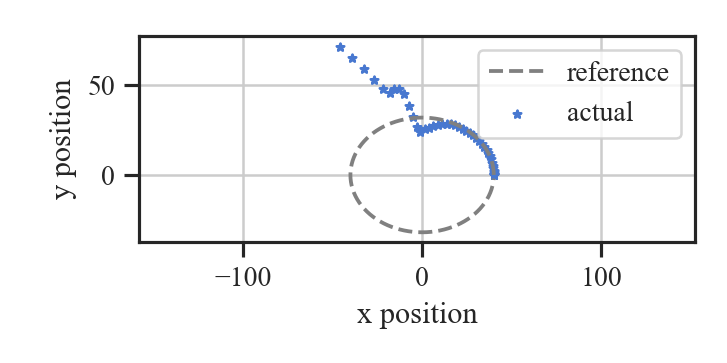

<IPython.core.display.Javascript object>


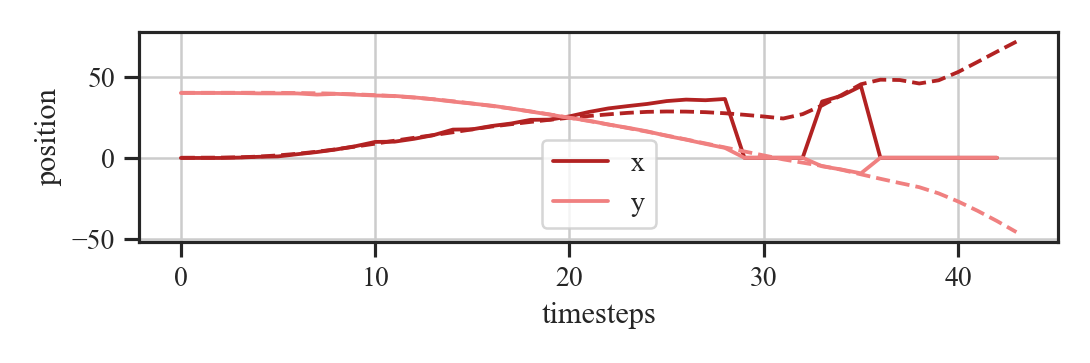

In [11]:
filetag = 'carla-uav'
scale = ex.CARLA_UAV_SCALE # multiplier to convert into meters


cl_perception = 'kernel'

for ref_rad in ['', 'small']:
    with open('{}{}CL_{}_interconnection_{}.pkl'.format(directory,ref_rad,cl_perception,filetag), 'rb') as input:
        interconnection_v = pickle.load(input)
    params = np.load('{}{}CL_{}_{}.npz'.format(directory,ref_rad,cl_perception,filetag))
    yref = params['yref']
    C = interconnection_v.controller.C

    plt.figure(figsize=[4,2])
    ax = plt.subplot(1,1,1)
    plt.grid()
    ax.set_axisbelow(True)

    plt.plot(scale*yref[:,1], scale*yref[:,0], '--', label='reference', color='grey')

    y_v = np.array(interconnection_v.xs) @ C.T
    plt.scatter(scale*y_v[:,1], scale*y_v[:,0], s=10, label='actual', marker='*')
    plt.axis('equal')
    plt.legend()
    plt.xlabel('x position'); plt.ylabel('y position'); 
    plt.tight_layout()

    plt.figure(figsize=[6,2])
    plt.grid()
    ax.set_axisbelow(True)
    ys_true = np.array(interconnection_v.xs) @ C.T
    ys_est = np.array(interconnection_v.controller.ys) 

    colors = ['firebrick','lightcoral']
    labels = ['x', 'y']
    for i in range(len(ys_true[0])):
        plt.plot(scale*ys_true[:,i], '--', color=colors[i])
        plt.plot(scale*ys_est[:,i], color=colors[i], label=labels[i])
    plt.legend()
    plt.xlabel('timesteps')
    plt.ylabel('position')
    plt.tight_layout()

In [12]:
fig, ax = plt.subplots(1, 1)
tracker = ex.IndexTracker(ax, interconnection_v.zs)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)

<IPython.core.display.Javascript object>

7

In [13]:
filetag = 'carla-car'

scale = ex.CARLA_CAR_SCALE # multiplier to convert into meters

cl_perception = 'kernel'
ref_rad = ''

with open('{}{}CL_{}_interconnection_{}.pkl'.format(directory,ref_rad,cl_perception,filetag), 'rb') as input:
    interconnection_v = pickle.load(input)
params = np.load('{}{}CL_{}_{}.npz'.format(directory,ref_rad,cl_perception,filetag))
yref = params['yref']
C = interconnection_v.controller.C

plt.figure(figsize=[4,2])
ax = plt.subplot(1,1,1)
plt.grid()
ax.set_axisbelow(True)

plt.plot(scale*yref[:,1], scale*yref[:,0], '--', label='reference', color='grey')

label_map = {'kernel':'NW', 'slam':'SLAM'}
colors_map = {'kernel':'firebrick', 'slam':'darkgoldenrod'}

for cl_perception in ['slam','kernel']:

    with open('{}CL_{}_interconnection_{}.pkl'.format(directory,cl_perception,filetag), 'rb') as input:
        interconnection_v = pickle.load(input)
    params = np.load('{}CL_{}_{}.npz'.format(directory,cl_perception,filetag))
    yref = params['yref']

    y_v = np.array(interconnection_v.xs) @ C.T
    plt.scatter(scale*y_v[:,1], scale*y_v[:,0], s=20, label=label_map[cl_perception], marker='*', 
                color=colors_map[cl_perception])
plt.axis('equal')
plt.xlim(-100,30)
plt.legend(loc='lower left')
plt.xlabel('x position'); plt.ylabel('y position'); 
plt.tight_layout()

plt.figure(figsize=[6,2])
plt.grid()
ax.set_axisbelow(True)
ys_true = np.array(interconnection_v.xs) @ C.T
ys_est = np.array(interconnection_v.controller.ys) 

colors = ['black','blue']
labels = ['x', 'y']
for i in range(len(ys_true[0])):
    plt.plot(scale*ys_true[:,i], '--', color=colors[i])
    plt.plot(scale*ys_est[:,i], color=colors[i], label=labels[i])
plt.legend()
plt.xlabel('timesteps')
plt.ylabel('position')
plt.tight_layout()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>